# DSA 데이터로 트랜스포머 엔코더를 이용한 분류 소스 작성

### 트렌스포머 모델: 순차적 데이터(문장 및 시계열 데이터)를 처리하는데 뛰어남

# 1. 데이터 불러오기

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('C:/Users/USER/Desktop/Deep_Learning/DSA_features.csv')
df

,T_xacc_mean,T_xacc_max,T_xacc_min,T_xacc_var,T_xacc_std,T_xacc_skew,T_yacc_mean,T_yacc_max,T_yacc_min,T_yacc_var,...,LL_ymag_std,LL_ymag_skew,LL_zmag_mean,LL_zmag_max,LL_zmag_min,LL_zmag_var,LL_zmag_std,LL_zmag_skew,activity,people
0,7.975714,8.1605,7.6823,0.014395,0.119981,-0.023319,1.083150,1.1832,0.99744,0.002208,...,0.000792,0.177075,-0.057119,-0.054963,-0.059241,6.778722e-07,0.000823,0.036729,sitting,p1
1,7.978250,8.1763,7.8472,0.007551,0.086896,0.552416,1.140865,1.2129,1.05810,0.000784,...,0.000860,-0.286918,-0.057268,-0.054945,-0.059589,7.032302e-07,0.000839,0.347471,sitting,p1
2,7.970894,8.0860,7.8470,0.003092,0.055603,0.100538,1.140962,1.2128,1.07960,0.000508,...,0.000762,-0.134430,-0.057068,-0.054711,-0.059065,6.268222e-07,0.000792,0.045579,sitting,p1
3,7.938412,8.1083,7.6901,0.003763,0.061343,-0.231914,1.165260,1.3170,1.07870,0.002173,...,0.000735,0.021485,-0.056422,-0.053670,-0.058310,8.011245e-07,0.000895,0.240690,sitting,p1
4,7.908930,8.1305,7.8322,0.001741,0.041731,2.042285,1.187504,1.2574,1.09450,0.000662,...,0.000824,-0.148229,-0.055801,-0.053313,-0.057815,6.853423e-07,0.000828,0.258429,sitting,p1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9115,8.280854,34.1980,-2.9038,28.080803,5.299132,1.350075,-1.491537,11.2240,-11.65100,14.670334,...,0.200829,-0.040701,0.297666,0.708480,-0.117430,4.135451e-02,0.203358,-0.310022,basketBall,p8
9116,9.591118,51.6970,-3.4129,35.722025,5.976791,2.981144,0.086304,6.9951,-11.76400,5.329897,...,0.148745,-0.266377,0.224716,0.554670,-0.250950,3.355704e-02,0.183186,-0.736410,basketBall,p8
9117,9.599113,27.9300,-1.0765,48.850886,6.989341,0.449237,-0.728367,3.7801,-8.36910,5.683022,...,0.310748,-0.009505,-0.237786,0.088854,-0.477260,2.026107e-02,0.142341,0.668438,basketBall,p8
9118,9.692482,72.7820,-2.6734,59.378336,7.705734,4.491114,-0.582724,6.1216,-8.85710,4.162963,...,0.156493,0.050624,0.533023,0.677800,0.055941,1.356379e-02,0.116464,-1.482489,basketBall,p8


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9120 entries, 0 to 9119
Columns: 272 entries, T_xacc_mean to people
dtypes: float64(270), object(2)
memory usage: 18.9+ MB


In [11]:
# 결측치 확인
df.isnull().sum()

T_xacc_mean     0
T_xacc_max      0
T_xacc_min      0
T_xacc_var      0
T_xacc_std      0
               ..
LL_zmag_var     0
LL_zmag_std     0
LL_zmag_skew    0
activity        0
people          0
Length: 272, dtype: int64

In [13]:
df.isnull().values.any()

False

### 데이터를 보면 데이터간의 시간적 순서가 중요하다.

### 1. 데이터 셋을 시계열 데이터로 전처리
### 2. 트랜스포머 인코더 모델 생성

# 2. 시계열 데이터 만들기

In [19]:
# 사람별, 활동별로 그룹화하여 데이터 개수를 세는 코드
activity_count = df.groupby(['people', 'activity']).size().reset_index(name='count')

# 결과 확인
print(activity_count)

# 사람 한 명이 하나의 활동을 했을 때, 몇 개의 데이터가 저장되어있는지 -> 60개의 데이터 저장.

    people                 activity  count
0       p1          ascendingStairs     60
1       p1               basketBall     60
2       p1             crossTrainer     60
3       p1        cyclingHorizontal     60
4       p1          cyclingVertical     60
..     ...                      ...    ...
147     p8  standingInElevatorStill     60
148     p8                  stepper     60
149     p8               walkingLot     60
150     p8     walkingTreadmillFlat     60
151     p8  walkingTreadmillIncline     60

[152 rows x 3 columns]


### 전체 데이터를 하나의 시퀀스로 처리하려면 시퀀스 길이 60으로 할 것인지, 30 or 20으로 줄여서 더 많은 시퀀스로 할 것인지 학습하면 된다.

### 타깃 데이터 'activity' 열이 수치형 데이터가 아니므로 인코딩

In [41]:
from sklearn.preprocessing import LabelEncoder

input = df.drop(['activity', 'people'], axis=1).values
target = df['activity'].values

le = LabelEncoder()
target = le.fit_transform(target)

# 인코딩 된 target 확인
target

array([12, 12, 12, ...,  1,  1,  1])

In [43]:
# 시계열 데이터 생성 함수 (활동이 동일한 시퀀스에 대해서만 입력과 타겟을 나눔)
def create_sequences_and_targets(data, target, sequence_length):
    inputs = []
    targets = []

    for i in range(len(data) - sequence_length):
        # 해당 시퀀스의 타겟이 동일한 활동인 경우에만 사용
        if len(set(target[i:i + sequence_length])) == 1:  # 시퀀스 내의 타겟이 모두 동일한지 확인
            seq = data[i:i + sequence_length]  # 입력 시퀀스
            inputs.append(seq)
            targets.append(target[i])  # 시퀀스의 첫 번째 값의 타겟을 사용

    return np.array(inputs), np.array(targets)

# 시퀀스 길이 설정
sequence_length = 60

# 시퀀스와 타겟 생성
input, target = create_sequences_and_targets(input, target, sequence_length)

# 생성된 시퀀스 데이터 크기 확인
print(f"입력 시퀀스 크기: {input.shape}")
print(f"타겟 크기: {target.shape}")

입력 시퀀스 크기: (7998, 60, 270)
타겟 크기: (7998,)


# 3. 훈련, 테스트 세트로 나누고, StandardScaler 전처리

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

train_input, test_input, train_target, test_target = train_test_split(input,target,test_size=0.2)

# StandardScaler는 2차원 배열을 받아야하기 때문에 현재 3차원인 시계열 데이터에는 바로 적용 불가
# 시계열 데이터를 2차원으로 reshape 하는 과정이 필요
train_input_reshaped = train_input.reshape(-1, train_input.shape[-1])  # (샘플 수 * 시퀀스 길이, 특성 수)
test_input_reshaped = test_input.reshape(-1, test_input.shape[-1])    # 같은 방식으로 변환

# StandardScaler 적용
ss = StandardScaler()
train_input_scaled = ss.fit_transform(train_input_reshaped)
test_input_scaled = ss.transform(test_input_reshaped)

# 다시 3차원으로 변환 (원래의 형태로 복원)
train_input_scaled = train_input_scaled.reshape(train_input.shape)
test_input_scaled = test_input_scaled.reshape(test_input.shape)

# 결과 확인
print(f"훈련 데이터 크기: {train_input_scaled.shape}")
print(f"테스트 데이터 크기: {test_input_scaled.shape}")
print(f"훈련 타겟 크기: {train_target.shape}")
print(f"테스트 타겟 크기: {test_target.shape}")

훈련 데이터 크기: (6398, 60, 270)
테스트 데이터 크기: (1600, 60, 270)
훈련 타겟 크기: (6398,)
테스트 타겟 크기: (1600,)


# 4. 트랜스포머 인코더 모델 정의

### 트랜스포머 인코더 모델 구조
### 
입력 임베딩: 입력 데이터를 적절한 차원으로 임베딩.### 

포지셔널 인코딩: 입력 데이터가 순차적인 관계를 학습할 수 있도록 순서 정보를 추### 가.

멀티헤드 어텐션: 입력 데이터 간의 상관관계를###  학습.

피드 포워드 네트워크: 학습된 정보를 처### 리하는 층.

최종 분류 층: 입력에 대한 예측을 수행하는 층.

In [50]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.models import Model

# 트랜스포머 인코더 블록을 함수로 정의
def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout=0.1):
    # 멀티헤드 어텐션
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attn_output = Dropout(dropout)(attn_output)

    # 잔차 연결 + Layer Normalization
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    # 피드포워드 네트워크
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)

    # 잔차 연결 + Layer Normalization
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# 트랜스포머 인코더 모델 함수 정의
def build_transformer_model(input_shape, num_classes, embed_dim=64, num_heads=4, ff_dim=128, num_layers=1, dropout=0.1):
    inputs = Input(shape=input_shape)

    # 인코더 임베딩 층
    x = Dense(embed_dim)(inputs)

    # 여러 트랜스포머 인코더 블록을 쌓음
    for _ in range(num_layers):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    # 분류를 위해 글로벌 평균 풀링
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = Dropout(dropout)(x)

    # Fully Connected Layer
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)

    # 출력층 (분류 문제: Softmax 사용)
    outputs = Dense(num_classes, activation="softmax")(x)

    # 모델 정의
    model = Model(inputs, outputs)
    return model

# 5. 하이퍼파라미터 설정, 모델 컴파일, 학습하기

In [53]:
# 하이퍼파라미터 설정
input_shape = (train_input.shape[1], train_input.shape[2])  # 시퀀스 길이, 피처 수
num_classes = len(np.unique(train_target))  # 클래스 수
dropout = 0.5 # 드롭아웃 비율


# 모델 빌드
model = build_transformer_model(input_shape, num_classes,dropout=dropout,num_layers=2)

# 모델 컴파일
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 60, 270)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 60, 64)            │          17,344 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention          │ (None, 60, 64)            │          66,368 │ dense[0][0], dense[0][0]   │
│ (MultiHeadAttention)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 60, 64)            │               0 │ multi_head_attention[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 60, 64)            │               0 │ dense[0][0],               │
│                               │                           │                 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 60, 64)            │             128 │ add[0][0]                  │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 60, 128)           │           8,320 │ layer_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 60, 64)            │           8,256 │ dense_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 60, 64)            │               0 │ dense_2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 60, 64)            │               0 │ layer_normalization[0][0], │
│                               │                           │                 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_1         │ (None, 60, 64)            │             128 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_1        │ (None, 60, 64)            │          66,368 │ layer_normalization_1[0][… │
│ (MultiHeadAttention)          │                           │                 │ layer_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_4 (Dropout)           │ (None, 60, 64)            │               0 │ multi_head_attention_1[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 60, 64)            │               0 │ layer_normalization_1[0][… │
│                               │                           │               

 Total params: 189,139 (738.82 KB)

 Trainable params: 189,139 (738.82 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=50, batch_size=32)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.3773 - loss: 2.0508 - val_accuracy: 0.9794 - val_loss: 0.0996
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.8848 - loss: 0.4085 - val_accuracy: 0.9987 - val_loss: 0.0052
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9624 - loss: 0.1631 - val_accuracy: 0.9987 - val_loss: 0.0022
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9673 - loss: 0.1225 - val_accuracy: 0.9981 - val_loss: 0.0052
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9732 - loss: 0.1009 - val_accuracy: 0.9994 - val_loss: 8.8079e-04
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.9770 - loss: 0.0765 - val_accuracy: 0.9987 - val_loss: 0.0048
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.9771 - loss: 0.0800 - val_accuracy: 1.0000 - val_loss: 3.8313e-06
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.9893 - loss: 0.0466 -

Text(0, 0.5, 'Loss')

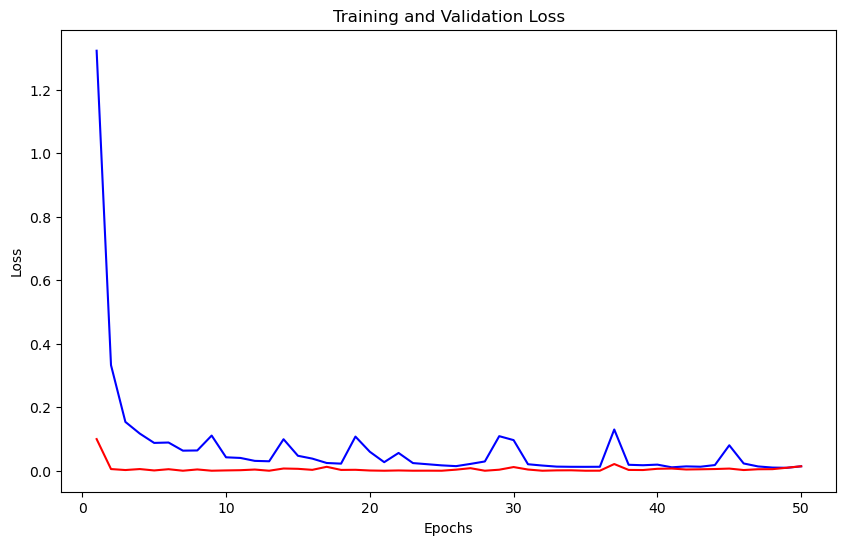

In [57]:
# loss 시각화
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

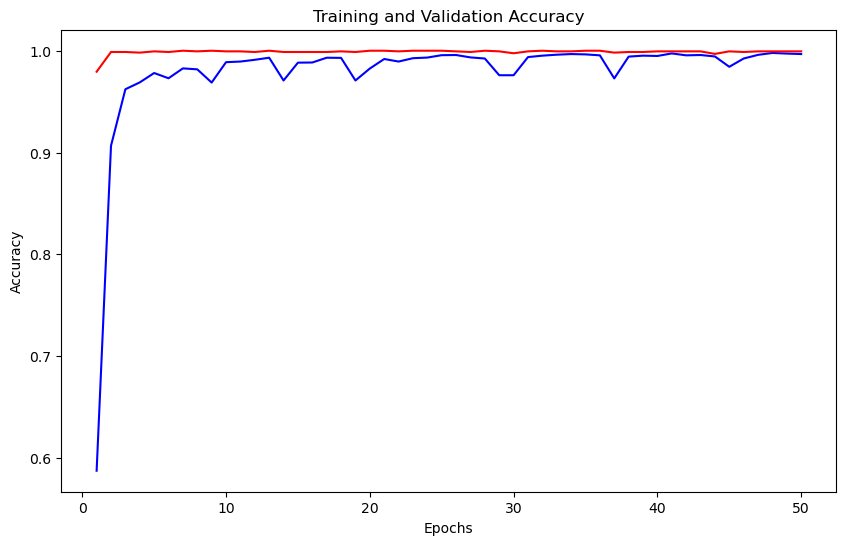

In [64]:
# accuracy 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [59]:
# 모델 평가
model.evaluate(test_input, test_target)

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9996 - loss: 0.0081


[0.013967994600534439, 0.9993749856948853]

# 6. 모델 과대접합 -> 모델 단순하게 만들기

###  Dense층의 차원들을 줄이기

In [68]:
# 하이퍼파라미터 설정 input_shape, num_classes, embed_dim=64, num_heads=4, ff_dim=128, num_layers=1, dropout=0.1
input_shape = (train_input.shape[1], train_input.shape[2])  # 시퀀스 길이, 피처 수
num_classes = len(np.unique(train_target))  # 클래스 수
dropout = 0.5 # 드롭아웃 비율
embed_dim = 16
num_heads = 2
ff_dim = 32
num_layers = 1


# 모델 빌드
model2 = build_transformer_model(input_shape, num_classes,dropout=dropout,num_layers=num_layers
                                 ,embed_dim=embed_dim,num_heads=num_heads,ff_dim=ff_dim)

# 모델 컴파일
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# 모델 요약
model2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 60, 270)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 60, 16)            │           4,336 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_2        │ (None, 60, 16)            │           2,160 │ dense_7[0][0],             │
│ (MultiHeadAttention)          │                           │                 │ dense_7[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 60, 16)            │               0 │ multi_head_attention_2[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 60, 16)            │               0 │ dense_7[0][0],             │
│                               │                           │                 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_4         │ (None, 60, 16)            │              32 │ add_4[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 60, 32)            │             544 │ layer_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_9 (Dense)               │ (None, 60, 16)            │             528 │ dense_8[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 60, 16)            │               0 │ dense_9[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_5 (Add)                   │ (None, 60, 16)            │               0 │ layer_normalization_4[0][… │
│                               │                           │                 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_5         │ (None, 60, 16)            │              32 │ add_5[0][0]                │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_1    │ (None, 16)                │               0 │ layer_normalization_5[0][… │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 16)                │               0 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_10 (Dense)              │ (None, 64)                │           1,088 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 9,955 (38.89 KB)

 Trainable params: 9,955 (38.89 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history2 = model2.fit(train_input, train_target, validation_data=(test_input, test_target), epochs=20, batch_size=32)

Epoch 1/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.1590 - loss: 2.7704 - val_accuracy: 0.9106 - val_loss: 0.9435
Epoch 2/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.5213 - loss: 1.4238 - val_accuracy: 0.9606 - val_loss: 0.2995
Epoch 3/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6609 - loss: 0.9765 - val_accuracy: 0.9837 - val_loss: 0.1504
Epoch 4/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7407 - loss: 0.7385 - val_accuracy: 0.9881 - val_loss: 0.1192
Epoch 5/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7733 - loss: 0.6278 - val_accuracy: 0.9987 - val_loss: 0.0610
Epoch 6/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7886 - loss: 0.5783 - val_accuracy: 1.0000 - val_loss: 0.0314
Epoch 7/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8138 - loss: 0.5198 - val_accuracy: 1.0000 - val_loss: 0.0246
Epoch 8/20
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8358 - loss: 0.4735 - val_accuracy: 1

Text(0, 0.5, 'Loss')

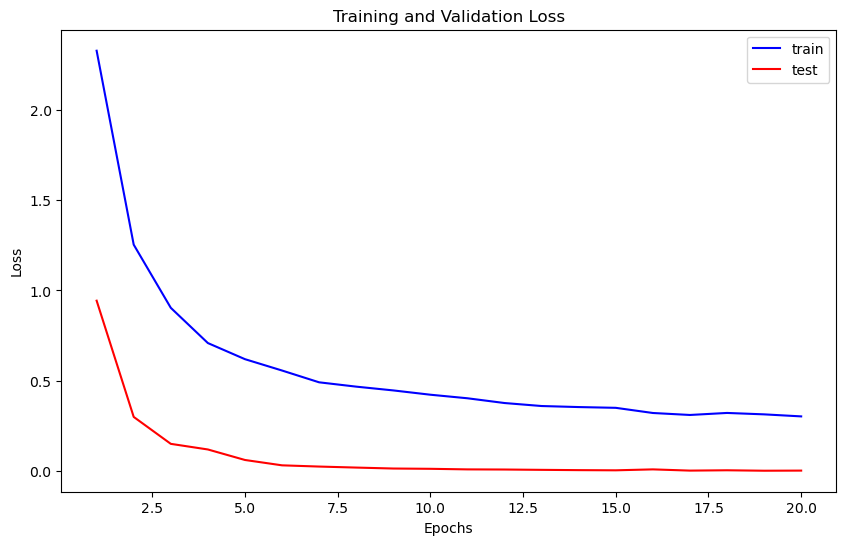

In [71]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

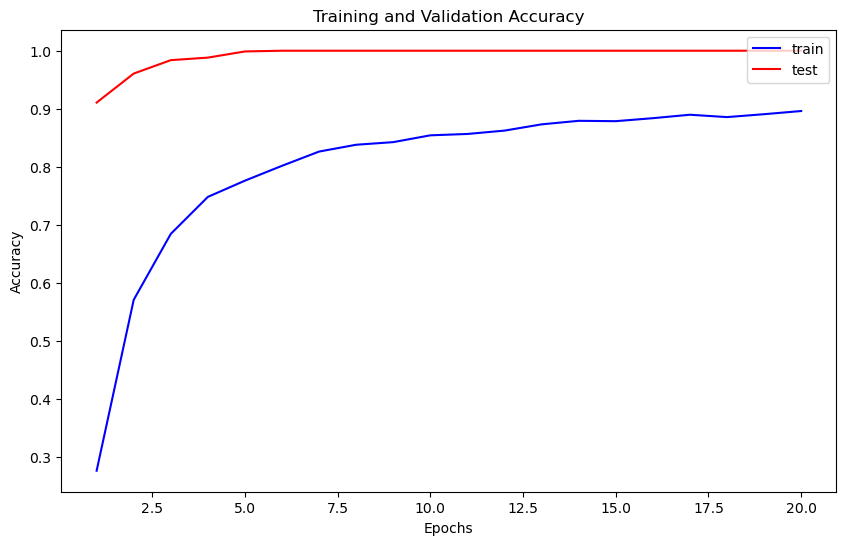

In [72]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')
plt.legend(['train', 'test'], loc='upper right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [74]:
model2.evaluate(test_input, test_target)

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 0.0023


[0.0021839372348040342, 1.0]

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


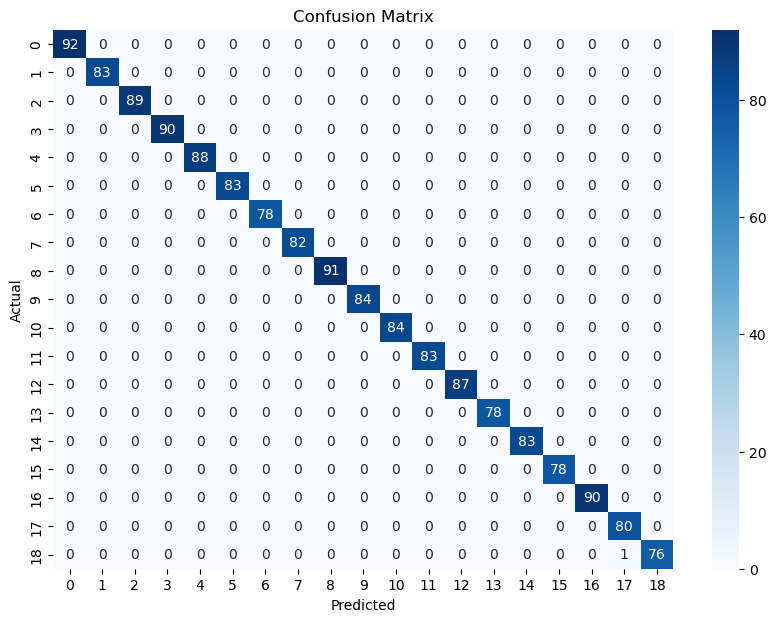

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       1.00      1.00      1.00        83
           2       1.00      1.00      1.00        89
           3       1.00      1.00      1.00        90
           4       1.00      1.00      1.00        88
           5       1.00      1.00      1.00        83
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        82
           8       1.00      1.00      1.00        91
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00        84
          11       1.00      1.00      1.00        83
          12       1.00      1.00      1.00        87
          13       1.00      1.00      1.00        78
          14       1.00      1.00      1.00        83
          15       1.00      1.00      1.00        78
          16       1.00      1.00      1.00        90
          17       0.99    

In [75]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(test_input)
y_pred = np.argmax(model.predict(test_input), axis=-1)

# 혼동 행렬
cm = confusion_matrix(test_target, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# 성능 보고서
print(classification_report(test_target, y_pred))